# Homework08

Exercises to practice unsupervised learning with clustering

## Goals

- Get more practice with the ML flow: encode -> normalize -> train -> evaluate
- Understand the tradeoffs of modeling parameters
- Develop intuition for different clustering models and when to use them

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py

In [3]:
pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import json
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir
from PIL import Image as PImage

from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import KMeansClustering, GaussianClustering

from image_utils import get_pixels, make_image

## Helmet Sizing

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/PSAM-5020-2025S-A/WK02) and then again in [Homework06](https://github.com/PSAM-5020-2025S-A/Homework06).

This is the dataset that has anthropometric information about U.S. Army personnel.

#### WARNING

Like we mentioned in class, this dataset is being used for these exercises due to the level of detail in the dataset and the rigorous process that was used in collecting the data.

This is a very specific dataset and should not be used to draw general conclusions about people, bodies, or anything else that is not related to the distribution of physical features of U.S. Army personnel.

In [5]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

Let's load it into a `DataFrame`, like last week.

In [6]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


### Unsupervised Learning

Let's pretend we are designing next-generation helmets with embedded over-the-ear headphones and we want to have a few options for sizes.

We could use clustering to see if there is a number of clusters that we can divide our population into, so each size covers a similar portion of the population.

We can follow similar steps to regression to create a clustering model that uses features about head and ear sizes:

1. Load dataset (done! 🎉)
2. Encode label features as numbers
3. Normalize the data
4. Separate the feature variables we want to consider (done below)
5. Pick a clustering algorithm
6. Determine number of clusters
7. Cluster data
8. Interpret results

For step $5$, it's fine to just pick an algorithm ahead of time to see what happens, but feel free to experiment and plot results for multiple clustering methods.

In [13]:
## Encode non-numerical features
encoder = OrdinalEncoder()
ansur_df['gender'] = encoder.fit_transform(ansur_df[['gender']])
ansur_df.head()

## Normalize the data
features_to_normalize = ['height', 'weight', 'ear.breadth', 'ear.length', 'ear.protrusion', 
                         'foot.breadth', 'foot.length', 'hand.breadth', 'hand.length', 'hand.palm','head.height','head.circumference']
scaler = StandardScaler()
ansur_df[features_to_normalize] = scaler.fit_transform(ansur_df[features_to_normalize])
ansur_df.head()



,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,0.0,-0.580787,-1.172301,1699,1645,-1.595311,-0.339199,-0.716543,-0.278534,-1.148478,-1.091728,-0.631450,-0.829835,-0.520526,-0.712215
1,30,1.0,-0.063917,0.961397,1749,1715,-0.040102,0.075180,-1.664859,0.172925,-0.631455,0.324677,-0.457501,0.011265,-0.942284,-0.548648
2,27,1.0,-0.322352,-1.587187,1684,1657,0.270940,-0.753577,0.547878,-1.030966,-0.688902,-0.147458,-0.805398,-1.530751,-0.857933,-2.947621
3,20,1.0,1.228259,0.309434,1878,1828,0.270940,-0.546388,-0.400438,0.774871,0.977061,1.583704,1.021064,1.413097,1.756972,0.650838
4,33,1.0,2.003565,-0.727781,1977,1883,1.204065,0.489559,1.496194,0.323411,0.460038,0.796812,0.412243,-0.128919,0.407344,-0.603170


In [14]:
## Separate the features we want to consider
features_to_cluster = ['height', 'weight', 'ear.breadth', 'ear.length', 'ear.protrusion', 
                         'foot.breadth', 'foot.length', 'hand.breadth', 'hand.length', 'hand.palm','head.height','head.circumference']
ansur_features = ansur_df[features_to_cluster]
ansur_features.head()


,height,weight,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,-0.580787,-1.172301,-1.595311,-0.339199,-0.716543,-0.278534,-1.148478,-1.091728,-0.631450,-0.829835,-0.520526,-0.712215
1,-0.063917,0.961397,-0.040102,0.075180,-1.664859,0.172925,-0.631455,0.324677,-0.457501,0.011265,-0.942284,-0.548648
2,-0.322352,-1.587187,0.270940,-0.753577,0.547878,-1.030966,-0.688902,-0.147458,-0.805398,-1.530751,-0.857933,-2.947621
3,1.228259,0.309434,0.270940,-0.546388,-0.400438,0.774871,0.977061,1.583704,1.021064,1.413097,1.756972,0.650838
4,2.003565,-0.727781,1.204065,0.489559,1.496194,0.323411,0.460038,0.796812,0.412243,-0.128919,0.407344,-0.603170


/tmp/ipykernel_1949/2600763416.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ansur_features['cluster'] = kmeans.labels_


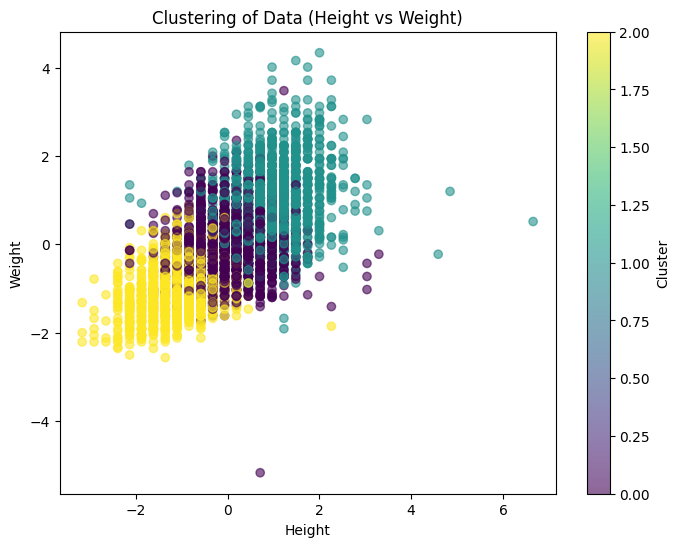

In [18]:
from sklearn.cluster import KMeans

## Create Clustering model
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(ansur_features)
ansur_features['cluster'] = kmeans.labels_
ansur_features.head()
## Run the model(s) on the data

## Check errors
ansur_features.isnull().sum()

## Plot clusters as function of 2 or 3 variables
import matplotlib.pyplot as plt

# Select two features to plot (e.g., height and weight)
x = ansur_features['height']
y = ansur_features['weight']

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=ansur_features['cluster'], cmap='viridis', alpha=0.6)
plt.title('Clustering of Data (Height vs Weight)')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.colorbar(label='Cluster')
plt.show()


### Interpretation

<span style="color:hotpink;">
Which clustering algorithm did you choose? : I used KMeans clustering<br>
Did you try a different one? -> Gaussian Models<br>
Do the clusters make sense ? Do they look balanced ?-> Yes, the clusters make sense if they group similar features, fairly balanced
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

## Figure out how many cluster

Experiment with the number of clusters to see if the initial choice makes sense.

The [WK08](https://github.com/PSAM-5020-2025S-A/WK08) notebook had a for loop that can be used to plot errors versus number of clusters.

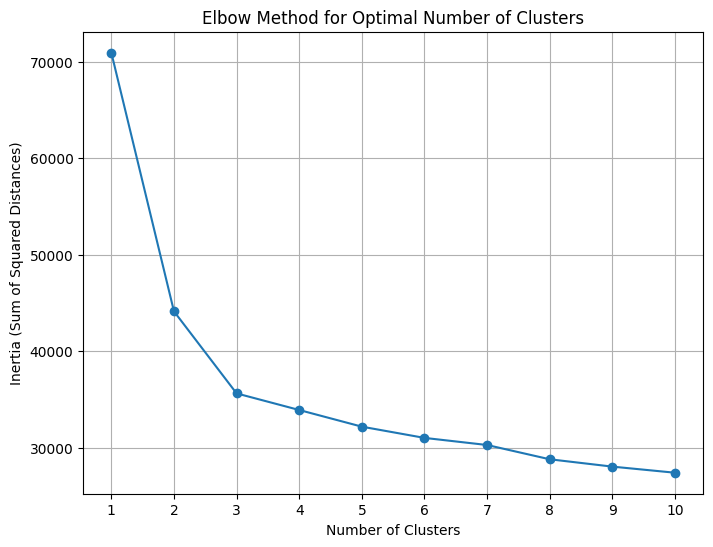

In [19]:
## Plot errors and pick how many cluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# List to store the inertia (errors) for each number of clusters
inertia = []

# Try different values for the number of clusters (e.g., from 1 to 10)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(ansur_features)  # Fit the model to the data
    inertia.append(kmeans.inertia_)  # Append the inertia (sum of squared distances)

# Plot the inertia vs number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


### Interpretation

<span style="color:hotpink;">
Based on the graphs of errors versus number of clusters, does it look like we should change the initial number of clusters ?<br>
How many clusters should we use ? Why ?

:Look for the "elbow" point where the inertia decreases slower. This shows the optimal number of clusters.
If the elbow is at 3 or 4 clusters, use that number. Adding more clusters won't improve the model much.
Use 3 or 4 clusters because it balances accuracy and simplicity.</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

### Revise Number of Clusters.

Re-run with the new number of clusters and plot the data in $2D$ or $3D$.

This can be the same graph as above.

/tmp/ipykernel_1949/121689622.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ansur_features['cluster'] = kmeans.labels_


cluster
0    2282
2    1761
1    1557
Name: count, dtype: int64


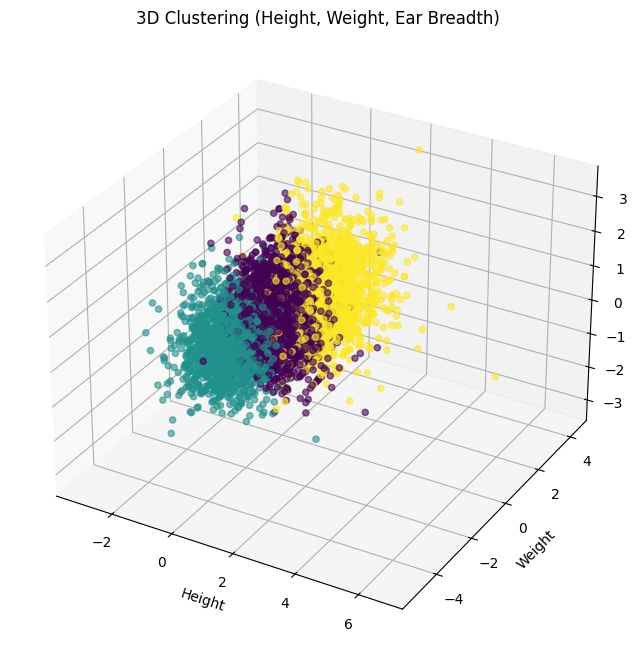

Inertia (Error): 35645.01903045467


In [20]:
## Re-run clustering with final number of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Final number of clusters (based on elbow method)
final_num_clusters = 3

# Re-run KMeans with the final number of clusters
kmeans = KMeans(n_clusters=final_num_clusters, random_state=42)
kmeans.fit(ansur_features)

# Add the cluster labels to the features DataFrame
ansur_features['cluster'] = kmeans.labels_

# Check the cluster assignments
print(ansur_features['cluster'].value_counts())

# Select three features for 3D visualization
x = ansur_features['height']
y = ansur_features['weight']
z = ansur_features['ear.breadth']  # You can change this feature to any other

# Plotting in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, c=ansur_features['cluster'], cmap='viridis', alpha=0.6)

# Set labels and title
ax.set_xlabel('Height')
ax.set_ylabel('Weight')
ax.set_zlabel('Ear Breadth')
ax.set_title('3D Clustering (Height, Weight, Ear Breadth)')

plt.show()

## Check errors
print("Inertia (Error):", kmeans.inertia_)



### Interpretation

<span style="color:hotpink;">
Do these look better than the original number of clusters?

Yes
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

## Image Organization

We have a dataset of about $600$ flower images that we might want to classify by species... eventually.

What we want to do first is take a look at all of the images and see what kind of images we have, what kind of colors our flowers have and see if there's any other visual information that could help us classify these images later.

We'll see how to use clustering and distances to organize our images by color to create a visualization that we cna use to get to know our dataset.

### Load Dataset

The following cell downloads the dataset:

In [21]:
!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/flowers.tar.gz | tar xz

Then, we can take a look at a few of the images:

In [22]:
IMG_DIR = "./data/image/flowers"

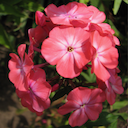

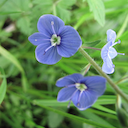

In [23]:
display(PImage.open(f"{IMG_DIR}/00_001.png"))
display(PImage.open(f"{IMG_DIR}/15_001.png"))

### Find Representative Colors

The overall process for organizing our images by color will be something like this:

1. Iterate over all files in the `data/image/flowers` directory, open each image file and treat it as a dataset
   1. Load image into a `DataFrame` where each pixel is a row and R,G,B values are columns/features
   2. Cluster into $2$ - $16$ colors
   3. Pick $3$ or $4$ representative colors
   4. Store image filenames and their representative colors in a Python object
2. Once all images have been processed we can order our dataset by different color characteristics: white to black, red to blue, hue value, brightness

### One Image

Let's step through the process of getting representative colors for one image, and then we can repeat this in a loop to process all of the flower images.

#### Open Image

The `PIL` library does all the work here:

In [24]:
# Open image
fname = "00_001.png"
pimg = PImage.open(f"{IMG_DIR}/{fname}").convert("RGB")

#### Put into `DataFrame`

We get the pixels and make a dataset/`DataFrame` out of them:

In [25]:
# Load into DataFrame
pxs = get_pixels(pimg)
pxs_df = pd.DataFrame(pxs, columns=["R", "G", "B"])

#### Cluster colors

Create a clustering object, cluster colors into $8$ clusters with `fit_predict()` and take a look at our color palette (`cluster_centers_`):

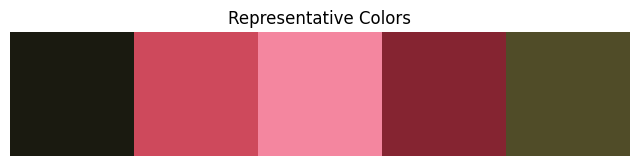

In [28]:
# TODO: Create Clustering object
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# TODO: Cluster by color
labels = kmeans.fit_predict(pxs_df)
cluster_centers = kmeans.cluster_centers_
# TODO: Take a look at the color palette (cluster_centers_)
plt.figure(figsize=(8, 2))
plt.imshow([cluster_centers.astype(int)])
plt.axis('off')
plt.title('Representative Colors')
plt.show()

# Store the image filename and its representative colors
image_colors = {
    'filename': fname,
    'representative_colors': cluster_centers
}

image_color_data = []
image_color_data.append(image_colors)

#### Checkpoint

<span style="color:hotpink;">
Does anything stand out about the colors?

: Mostly red
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

#### Reconstruct Image

Since we're only doing one image for now, let's take a look at the clustering result.

This is like in the lecture notebook. We'll start with an empty pixel array and as we iterate through the `DataFrame` of cluster ids we append the corresponding colors to it.

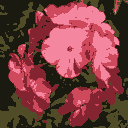

In [32]:
# Create an empty pixel array to store the reconstructed pixels
pxs_post = []

# Iterate through each pixel's cluster label and append the corresponding cluster center color
for label in labels:
    # Append the color corresponding to the label (cluster center)
    pxs_post.append(cluster_centers[label])

# Convert the list to a numpy array
pxs_post_array = np.array(pxs_post)

# Reshape the array back to the original image shape
image_width, image_height = pimg.size
pxs_post_array = pxs_post_array.reshape((image_height, image_width, 3))

# Convert the array back to an image
reconstructed_image = PImage.fromarray(pxs_post_array.astype(np.uint8))

# Display the reconstructed image
display(reconstructed_image)


Now we can look at the image. If this next cell gives errors about using `float` values in images, just make sure the pixel values that are being appended above are all whole number `int` values.

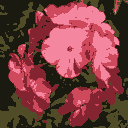

In [35]:
display(make_image(pxs_post, width=pimg.size[0]))


#### Checkpoint

<span style="color:hotpink;">
How does changing the number of clusters affect the resulting image?<br>Try some lower values like <code>2</code> and <code>4</code>, and also some higher ones like <code>12</code> and <code>16</code>. Take a look at a different image.
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

#### Pick Colors

Ok, we have some representative colors for our images. We should keep more than one color, but maybe we don't have to keep $12$.

We can use the `value_counts()` function of our `DataFrame` to see how many pixels are represented by each of our cluster colors:

In [39]:
# Count how many pixels belong to each cluster (color)
cluster_counts = pd.Series(labels).value_counts().sort_values(ascending=False)

# Display the counts of pixels per cluster, ordered by descending counts
print(cluster_counts)

# Pick the top N clusters based on the counts (e.g., top 3)
top_n_clusters = cluster_counts.head(3).index  # This gets the top N cluster indices

# Get the representative colors for the top clusters
top_colors = cluster_centers[top_n_clusters]

# Print out the top colors (RGB values)
print(top_colors)


0    5096
3    3204
2    2920
1    2684
4    2480
Name: count, dtype: int64
[[ 26.62114364  26.39457654  16.24444881]
 [133.79668439  36.26681264  49.43321864]
 [244.63291139 134.9449196  159.05302771]]


Since what we are really trying to do here is get some information about the colors of the flowers present in our images, and given the type of images we have, we can start by assuming that the flower colors will be in the top-$4$ clusters returned by `value_counts()`.

We can revisit this assumption later. We might also want to add some filters here to ignore sky and vegetation colors (blues and greens) and only keep flower colors.

For now, let's just grab the top-$4$ colors from `value_counts()`, remembering we want to keep their rounded `int` values and not the default `float` values in `cluster_centers_`.

In [42]:
# Object to keep colors for each file
file_info = {
  "filename": fname,
  "colors": []
}

# Get the top-4 clusters (or any number based on your preference)
top_n = 4
top_clusters = cluster_counts.head(top_n).index

# Iterate through the top clusters and get corresponding colors
for cluster_idx in top_clusters:
    # Round the cluster color values to integers
    rounded_color = np.round(cluster_centers[cluster_idx]).astype(int)
    # Add the rounded color to the file_info dictionary
    file_info["colors"].append(tuple(rounded_color))  




In [43]:
display(file_info)

{'filename': '00_001.png',
 'colors': [(np.int64(27), np.int64(26), np.int64(16)),
  (np.int64(134), np.int64(36), np.int64(49)),
  (np.int64(245), np.int64(135), np.int64(159)),
  (np.int64(206), np.int64(74), np.int64(92))]}

#### Checkpoint

<span style="color:hotpink;">
Why might we want to cluster into <code>8</code> or even <code>12</code> colors when in the end we're only keeping <code>4</code>?

: We cluster into 8 or 12 colors to capture more color details, then select the top 4 that matter most for flowers. This helps us get a better representation of the colors.
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

### Iterate and Cluster

We've processed one image, now let's process $600$... for-loops FTW!

We'll need to loop through all of the images in our directory and repeat the process above for each one of them.

We can create a function that takes a filename as input and returns the top-$4$ colors for that image, or... we can just put all of the clustering logic in the body of a for loop. Whichever is easiest.

Let's get started.

In [44]:
# list of all files in the flowers directory
flower_files = sorted([f for f in listdir(IMG_DIR) if f.endswith(".png")])

Here's the loop. In the end we want our `file_colors` list to have objects that have a filename and $4$ colors associated with each filename. Something like:

```py
[
  {
    "filename": "00_001.png",
    "colors": [[12,44,12], [112,144,62],  [12,84,112], [212,144,102]]
  },
  {
    "filename": "00_002.png",
    "colors": [[22,24,28], [112,114,122], [128,200,2], [250,240,230]]
  },
  ...
]
```

This can take a while to run (up to a minute for $600$ images). We can use slicing to test our logic on a subset of `flower_files` before processing all $600$ images.

In [45]:
# List to keep colors for each file
file_colors = []

# Iterate over each image in the directory
for fname in flower_files:
    # Open the image
    pimg = PImage.open(f"{IMG_DIR}/{fname}").convert("RGB")
    
    # Get pixels and create DataFrame
    pxs = get_pixels(pimg)
    pxs_df = pd.DataFrame(pxs, columns=["R", "G", "B"])
    
    # Apply KMeans clustering (as done previously)
    kmeans = KMeans(n_clusters=12, random_state=42)  # You can adjust the number of clusters
    labels = kmeans.fit_predict(pxs_df)
    cluster_centers = kmeans.cluster_centers_
    
    # Count pixels for each cluster and get top clusters
    cluster_counts = pd.Series(labels).value_counts().sort_values(ascending=False)
    top_n = 4  # Keep top 4 clusters
    top_clusters = cluster_counts.head(top_n).index
    
    # Object to store colors for this image
    file_info = {
        "filename": fname,
        "colors": []
    }
    
    # Get the representative colors for the top clusters
    for cluster_idx in top_clusters:
        rounded_color = np.round(cluster_centers[cluster_idx]).astype(int)
        file_info["colors"].append(list(rounded_color))  # Add color as a list
    
    # Append the object to the file_colors list
    file_colors.append(file_info)

# Display the file_colors list
display(file_colors)


[{'filename': '00_001.png',
  'colors': [[np.int64(35), np.int64(34), np.int64(20)],
   [np.int64(14), np.int64(16), np.int64(11)],
   [np.int64(143), np.int64(44), np.int64(61)],
   [np.int64(245), np.int64(129), np.int64(154)]]},
 {'filename': '00_002.png',
  'colors': [[np.int64(169), np.int64(72), np.int64(163)],
   [np.int64(20), np.int64(24), np.int64(16)],
   [np.int64(185), np.int64(92), np.int64(185)],
   [np.int64(40), np.int64(42), np.int64(31)]]},
 {'filename': '00_003.png',
  'colors': [[np.int64(222), np.int64(50), np.int64(87)],
   [np.int64(178), np.int64(21), np.int64(56)],
   [np.int64(237), np.int64(71), np.int64(109)],
   [np.int64(207), np.int64(33), np.int64(70)]]},
 {'filename': '00_004.png',
  'colors': [[np.int64(45), np.int64(52), np.int64(30)],
   [np.int64(244), np.int64(79), np.int64(115)],
   [np.int64(247), np.int64(101), np.int64(146)],
   [np.int64(23), np.int64(32), np.int64(17)]]},
 {'filename': '00_005.png',
  'colors': [[np.int64(218), np.int64(107)

#### Order Images (almost)

We have a list with objects that keep track of filenames and representative colors. We could create a `DataFrame` or csv dataset with these, but let's go ahead and just use this directly in this format.

What we want to do is re-order our list of objects, but using a `key` function that takes each object's colors into consideration.

We'll look into how to do this dynamically later, but for now let's order our images by something like _brightness_. It's _like_ brightness because what we'll do is measure how close each image is to the white color `(255,255,255)`.

We'll need some helper functions first:

- `color_distance()`: takes $2$ colors and returns the distance between them
- `min_color_distance()`: given a reference color and a list of colors, returns the distance between the reference color and the closest color in the list

In [46]:
import numpy as np

# Function to calculate the Euclidean distance between two colors
def color_distance(c0, c1):
    # Convert to numpy arrays for vectorized operations
    c0 = np.array(c0)
    c1 = np.array(c1)
    
    # Euclidean distance formula: sqrt((R1-R2)^2 + (G1-G2)^2 + (B1-B2)^2)
    return np.linalg.norm(c0 - c1)
# Function to find the minimum distance between a reference color and a list of colors
def min_color_distance(reference_color, color_list):
    # Compute the distance to each color in the list
    distances = [color_distance(reference_color, color) for color in color_list]
    
    # Return the smallest distance
    return min(distances)
# Function to calculate the average color of an image
def average_color(colors):
    # Calculate the mean RGB values for the top colors
    avg_color = np.mean(colors, axis=0)
    return avg_color

# Sort images by their "closeness" to white (brightness)
file_colors_sorted = sorted(file_colors, key=lambda x: min_color_distance((255, 255, 255), x['colors']))

# Display the sorted list
display(file_colors_sorted)


[{'filename': '01_001.png',
  'colors': [[np.int64(52), np.int64(79), np.int64(41)],
   [np.int64(25), np.int64(39), np.int64(21)],
   [np.int64(86), np.int64(122), np.int64(63)],
   [np.int64(252), np.int64(252), np.int64(251)]]},
 {'filename': '04_001.png',
  'colors': [[np.int64(5), np.int64(5), np.int64(5)],
   [np.int64(12), np.int64(13), np.int64(12)],
   [np.int64(250), np.int64(250), np.int64(249)],
   [np.int64(32), np.int64(36), np.int64(25)]]},
 {'filename': '07_009.png',
  'colors': [[np.int64(85), np.int64(118), np.int64(153)],
   [np.int64(107), np.int64(142), np.int64(175)],
   [np.int64(247), np.int64(248), np.int64(249)],
   [np.int64(75), np.int64(60), np.int64(17)]]},
 {'filename': '18_018.png',
  'colors': [[np.int64(58), np.int64(71), np.int64(43)],
   [np.int64(38), np.int64(47), np.int64(29)],
   [np.int64(246), np.int64(242), np.int64(252)],
   [np.int64(78), np.int64(95), np.int64(58)]]},
 {'filename': '06_011.png',
  'colors': [[np.int64(245), np.int64(246), n

Some tests for the `color_distance()` function:

In [47]:
# Some tests for the color_distance() function
print(color_distance([0,0,0], [255,255,255]), "should be", 255*3**.5)
print(color_distance([0,100,0], [100,100,0]), "should be", 100)
print(color_distance([55,222,120], [91,51,192]), "should be", 189)
print(color_distance([147,207,246], [87,57,50]), "should be", 254)
print(color_distance([12,250,126], [112,10,195]), "should be", 269)
print(color_distance([106,71,61], [105,136,100]), "should be", 75.81)

441.6729559300637 should be 441.67295593006367
100.0 should be 100
189.0 should be 189
254.0 should be 254
269.0 should be 269
75.80897044545586 should be 75.81


In [48]:
# Function to find the minimum distance between a reference color and a list of colors
def min_color_distance(ref_color, color_list):
    # Calculate the distance between the reference color and each color in the list
    distances = [color_distance(ref_color, color) for color in color_list]
    
    # Return the smallest distance
    return min(distances)


Three tests for the `min_color_distance()` function:

In [49]:
# Some tests for the color_distance() function
print(min_color_distance([0,0,0], [[255,255,255],[0,100,0],[100,100,0],[58,58,58]]), "should be", 100)
print(min_color_distance([0,0,0], [[255,255,255],[0,100,0],[100,100,0],[58,57,58]]), "should be", 99.88)
print(min_color_distance([91,51,192], [[147,207,246],[87,57,50],[12,250,126],[112,10,195]]), "should be", 46.16)

100.0 should be 100
99.88493379884676 should be 99.88
46.16275555033516 should be 46.16


#### Order Images (for real now)

Alright. We have a function that can be used to order our images by their distance to a given color.

Let's order our images by how close they are to the brightest color `(255,255,255)`. We'll define a `key` function that, given an object from our `file_colors` list, returns how close that image is to the color `(255,255,255)`.

In [50]:
# Function to calculate the distance of an image to the color white (255, 255, 255)
def by_bright_dist(A):
    # Get the list of top colors for the image
    colors = A['colors']
    
    # Use the min_color_distance function to get the minimum distance to white
    return min_color_distance((255, 255, 255), colors)


Order the list and write out a `JSON` file with the image order.

In [51]:
file_colors_sorted = sorted(file_colors, key=by_bright_dist)

In [52]:
files_sorted = [A["filename"] for A in file_colors_sorted]

with open("./data/flower_order.json", "w") as ofp:
  json.dump(files_sorted, ofp)

### Viewing Results

We can check the results by running a webserver and looking at a simple web page that orders the images according to the resulting `JSON` file from above.

We'll make use of the [`Live Server`](https://marketplace.visualstudio.com/items?itemName=ritwickdey.LiveServer) VSCode extension.

We can start the server by clicking on the "_Go Live_" button towards the right hand side of the bar at the very bottom of our text editor:

<img src="./imgs/go_live.jpg" width="600px">

Clicking the "_Go Live_" button in Codespace should open up a new tab with a plain html navigation view of our repository. Clicking on the `html/` directory should open up a web page with all of the flower images. If not, you can use your Codespace url to try to find the web server address.

If your Codespace url is something like:<br>`https://mango-special-giggle-v6v7asd322f7p6.github.dev/`

Then, the webserver should be running at:<br>`https://mango-special-giggle-v6v7asd322f7p6-5500.app.github.dev/`

### Review, Contemplate, Experiment

Yes, images with white parts are towards the beginning, but the images towards the end aren't necessarily the ones with dark flowers, but are the ones that have all of their representative colors farthest away from white `(255,255,255)`, which includes very saturated colors/images.

A couple of interesting experiments here could be:
- Decrease the number of clusters or the number of colors kept after clustering.
- Use different colors as the reference for the distance functions. For example, create `by_gold_dist()` or `by_purple_dist()` functions to use as the `key` for sorting.
- Order the list of cluster colors by [hue](https://stackoverflow.com/questions/23090019/fastest-formula-to-get-hue-from-rgb). This can be a bit tricky to get right because some colors, like white, black and gray, don't have a unique value for hue, but depend on other aspects of the color, like saturation and lightness, to be well-defined.

In [ ]:
# TODO: experiment with number of clusters, number of colors, reference colors or hue distances

### Interpretation

<span style="color:hotpink;">
What did you try ? What happened ?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

### Conclusion

It's challenging to define a set of functions that will perfectly order our flowers by color without first having to define very specific color values for filtering and corner-cases. At a high-level, we can imagine that this is because color is a $3$-dimensional value, and we're using it to organize our images into a single-dimensional order.

The beginning of our ordering is usually pretty good, since there's only one way for a color to be _close_ to our reference color, but the ordering gets less consistent towards the end because there are many different ways for a color to be _far_ from the reference color.

Next week we'll see a very powerful technique that, amongst other things, will help us get around this kind of "_dimensionality mismatch_".